In [1]:
import os
import allel
from numba import njit
import malariagen_data

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import seaborn as sns
import plotly.express as px

In [2]:
from zmq import NULL
@njit()
def ibdscans(geno, pos):
    """
    Scans across two genotype vectors, checking and recording SNPs which are either
    are homozygous but different (IBD1 breakpoint) or have any alleles different (IBD2 breakpoint)
    """

    geno1 = geno[:, 0]
    geno2 = geno[:, 1]

    ibd1_breakpoints = []
    ibd2_breakpoints = []
    # Scan right along genome, as long as two inds are not both homozygous but different
    for pos_idx in range(pos.shape[0]):

        gn1 = geno1[pos_idx]
        gn2 = geno2[pos_idx]

        # if both alleles are not identical, record the position
        if not (gn1 == gn2).all() and (-1 not in gn1 and -1 not in gn2):
            ibd2_breakpoints.append(pos_idx)
            # if both alleles are not identical and not missing, and both are homozygous, record the position
            if (gn1[0] == gn1[1]) and (gn2[0] == gn2[1]) and ((gn1 != gn2).all()) and (-1 not in gn1 and -1 not in gn2):
                ibd1_breakpoints.append(pos_idx)

    return np.array(ibd1_breakpoints), np.array(ibd2_breakpoints)

def detect_ibd_segments(contig, sample_sets1=None, cohort_size1=None, sample_query1=None, sample_sets2=None, cohort_size2=None, sample_query2=None, prefix="", site_mask='gamb_colu', save_path=None, ibd1_size = 100_000, ibd2_size = 10_000, use_n_snps = False):
    """
    Loads genotype data, and runs IBD scan on each pair of individuals, writing IBD segments to
    a .tsv file.
    """
    from itertools import combinations

    geno, pos, sample_ids = load_genotypes(
        contig=contig,
        sample_sets1=sample_sets1,
        cohort_size1=cohort_size1,
        sample_query1=sample_query1,
        sample_sets2=sample_sets2,
        cohort_size2=cohort_size2,
        sample_query2=sample_query2,
        site_mask=site_mask
    )

    for x,y in tqdm(combinations(range(geno.shape[1]), 2)):
        sample1 = sample_ids[x]
        sample2 = sample_ids[y]
        ibd1, ibd2 = ibdscans(geno.take([x,y], axis=1), pos)

        if save_path:
          ibd1_path = save_path + f"/{prefix}.{contig}.ibd1.tsv"
          ibd2_path = save_path + f"/{prefix}.{contig}.ibd2.tsv"
        else:
          ibd1_path = f"{prefix}.{contig}.ibd1.tsv"
          ibd2_path = f"{prefix}.{contig}.ibd2.tsv"

        ## IBD 1
        pos_ibd1 = pos[ibd1]
        n_snps_ibd1 = np.ediff1d(ibd1)
        sizes_ibd1 = np.ediff1d(pos_ibd1)
        ibd1_segments_df = pd.DataFrame({'size':sizes_ibd1,
                                      'n_snps':n_snps_ibd1,
                                      'start':pos_ibd1[:-1],
                                      'end':pos_ibd1[1:]})
        if use_n_snps:
          ibd1_segments_df = ibd1_segments_df.query("n_snps > " + str(ibd1_size))
        else:
          ibd1_segments_df = ibd1_segments_df.query("size > " + str(ibd1_size))
        ibd1_segments_df.assign(
            contig=contig,
            index1=x,
            index2=y,
            sample1=sample1,
            sample2=sample2).to_csv(ibd1_path, sep="\t", mode='a', index = False, header=not os.path.exists(ibd1_path))

        ## IBD 2
        pos_ibd2 = pos[ibd2]
        n_snps_ibd2 = np.ediff1d(ibd2)
        sizes_ibd2 = np.ediff1d(pos_ibd2)
        ibd2_segments_df = pd.DataFrame({'size':sizes_ibd2,
                                      'n_snps':n_snps_ibd2,
                                      'start':pos_ibd2[:-1],
                                      'end':pos_ibd2[1:]})
        if use_n_snps:
          ibd2_segments_df = ibd2_segments_df.query("n_snps > " + str(ibd1_size))
        else:
          ibd2_segments_df = ibd2_segments_df.query("size > " + str(ibd1_size))
        ibd2_segments_df.assign(
            contig=contig,
            index1=x,
            index2=y,
            sample1=sample1,
            sample2=sample2).to_csv(ibd2_path, sep="\t", mode="a", index = False, header=not os.path.exists(ibd2_path))
    return sample_ids


def load_genotypes(contig, sample_sets1, cohort_size1, sample_query1, sample_sets2, cohort_size2, sample_query2, site_mask='gamb_colu'):
    """
    Loads SNP calls and throws out invariant, singleton and doubleton sites, which
    massively speeds up IBD scanning algorithm.
    """

    import xarray as xr

    print("Loading genotypes")
    ds_snps1 = ag3.snp_calls(region=contig, sample_sets=sample_sets1, cohort_size=cohort_size1, sample_query=sample_query1, site_mask=site_mask)
    ds_snps2 = ag3.snp_calls(region=contig, sample_sets=sample_sets2, cohort_size=cohort_size2, sample_query=sample_query2, site_mask=site_mask)
    ds_snps = xr.concat([ds_snps1, ds_snps2], dim='samples')
    geno = allel.GenotypeDaskArray(ds_snps['call_genotype'].values)
    sample_ids = ds_snps['sample_id'].values
    print("computing allele counts")
    ac = geno.count_alleles().compute()

    seg = ac.is_segregating()
    dbl = ac.is_doubleton(allele=1)
    dbl2 = ac.is_doubleton(allele=2)
    dbl3 = ac.is_doubleton(allele=3)
    dbl = np.logical_or(dbl, np.logical_or(dbl2, dbl3))
    sngl = ac.is_singleton(allele=1)
    sngl2 = ac.is_singleton(allele=2)
    sngl3 = ac.is_singleton(allele=3)

    mask = np.logical_and(seg, ~np.logical_or(dbl, np.logical_or(sngl, np.logical_or(sngl2, sngl3))))
    print(f"retaining {mask.sum()} variants and removing {(~mask).sum()}")

    geno = geno[mask].compute().values
    pos = ds_snps['variant_position'].values[mask]

    return geno, pos, sample_ids

In [3]:
ag3 = malariagen_data.Ag3(pre=True)

In [4]:
def summarise_ibd_data(prefix='coluzzii', ibd1_min_size=1000, ibd2_min_size=100, save_path=None, use_snps = False):
    from dask import dataframe as dd
    import malariagen_data

    #ag3 = malariagen_data.Ag3("gs://vo_agam_release/", pre=True)
    genome_size = np.sum([ag3.genome_sequence(contig).shape[0] for contig in ag3.virtual_contigs + ('X',)])

    ibd1_list = []
    ibd2_list = []
    for i, contig in enumerate(ag3.virtual_contigs + ('X',)):
        if save_path:
          ibd1_path = save_path + f"/{prefix}.{contig}.ibd1.tsv"
          ibd2_path = save_path + f"/{prefix}.{contig}.ibd2.tsv"
        else:
          ibd1_path = f"{prefix}.{contig}.ibd1.tsv"
          ibd2_path = f"{prefix}.{contig}.ibd2.tsv"
        print(f"reading ibd1 {contig}...")
        if use_snps:
          ibd1_df = dd.read_csv(ibd1_path, sep="\t").query(f"n_snps > {ibd1_min_size}")
        else:
          ibd1_df = dd.read_csv(ibd1_path, sep="\t").query(f"size > {ibd1_min_size}")
        print(f"reading ibd2 {contig}...")
        if use_snps:
          ibd2_df = dd.read_csv(ibd2_path, sep="\t").query(f"n_snps > {ibd2_min_size}")
        else:
          ibd2_df = dd.read_csv(ibd2_path, sep="\t").query(f"size > {ibd2_min_size}")

        ibd1_data = ibd1_df.groupby(['index1', 'index2']).agg({'size':'sum', 'n_snps':'sum'}).assign(contig=contig)
        ibd2_data = ibd2_df.groupby(['index1', 'index2']).agg({'size':'sum', 'n_snps':'sum'}).assign(contig=contig)
        ibd1_list.append(ibd1_data)
        ibd2_list.append(ibd2_data)

    print("computing...")
    ibd1_stats = dd.concat(ibd1_list).compute()
    ibd2_stats= dd.concat(ibd2_list).compute()
    if save_path:
      ibd1_stats.to_csv(save_path + "/ibd1.per_contig.tsv", sep="\t")
      ibd2_stats.to_csv(save_path + "/ibd2.per_contig.tsv", sep="\t")
    else:
      ibd1_stats.to_csv("ibd1.per_contig.tsv", sep="\t")
      ibd2_stats.to_csv("ibd2.per_contig.tsv", sep="\t")

    ibd1_stats = ibd1_stats.reset_index().rename(columns={'size':'ibd1_size'}).groupby(['index1', 'index2']).agg({'ibd1_size':'sum'}).assign(ibd1_fraction=lambda x: x['ibd1_size']/genome_size)
    ibd2_stats = ibd2_stats.reset_index().rename(columns={'size':'ibd2_size'}).groupby(['index1', 'index2']).agg({'ibd2_size':'sum'}).assign(ibd2_fraction=lambda x: x['ibd2_size']/genome_size)
    ibd_stats = pd.concat([ibd1_stats, ibd2_stats], axis=1)

    if save_path:
      ibd_stats.to_csv(save_path + f"/{prefix}.ibd.summary.tsv", sep="\t")
    else:
      ibd_stats.to_csv(f"{prefix}.ibd.summary.tsv", sep="\t")
    return ibd_stats, ibd1_stats, ibd2_stats

In [5]:
def compute_ibd(sample_sets1, cohort_size1, sample_query1, sample_sets2, cohort_size2, sample_query2, site_mask, prefix, save_path, ibd1_size, ibd2_size):
  for contig in ag3.virtual_contigs + ('X',):
    print(contig)
    sample_names = detect_ibd_segments(
        contig=contig,
        sample_sets1=sample_sets1,
        cohort_size1=cohort_size1,
        sample_query1=sample_query1,
        sample_sets2=sample_sets2,
        cohort_size2=cohort_size2,
        sample_query2=sample_query2,
        site_mask=site_mask,
        prefix=prefix,
        save_path=save_path,
        ibd1_size = ibd1_size,
        ibd2_size = ibd2_size
    )
  ibd_stats, ibd1_stats, ibd2_stats = summarise_ibd_data(prefix=prefix, ibd1_min_size= ibd1_size, ibd2_min_size= ibd2_size, save_path = save_path)
  ibd1_ar = np.zeros((20,20,))
  ibd2_ar = np.zeros((20,20,))
  for index, row in ibd_stats.iterrows():
    if not np.isnan(row['ibd1_fraction']):
      ibd1_ar[index[0],index[1]] = row['ibd1_fraction']
      ibd1_ar[index[1],index[0]] = row['ibd1_fraction']
    if not np.isnan(row['ibd2_fraction']):
      ibd2_ar[index[0],index[1]] = row['ibd2_fraction']
      ibd2_ar[index[1],index[0]] = row['ibd2_fraction']
  ibd1_df = pd.DataFrame(data = ibd1_ar,
                index = sample_names,
                columns = sample_names
                )
  ibd2_df = pd.DataFrame(data = ibd2_ar,
                index = sample_names,
                columns = sample_names
                )
  return ibd1_df, ibd2_df, sample_names

Mayotte (gambiae) & Angola (coluzzii)

In [7]:
fr_ao_ibd1_df, fr_ao_ibd2_df, _ = compute_ibd(
        sample_sets1='AG1000G-FR',
        cohort_size1=10,
        sample_query1="taxon == 'gambiae'",
        sample_sets2='AG1000G-AO',
        cohort_size2=10,
        sample_query2=None,
        site_mask='gamb_colu',
        prefix="",
        save_path="FR_AO_50000_5000",
        ibd1_size = 50000,
        ibd2_size = 5000
    )

2RL
Loading genotypes
computing allele counts
retaining 2611555 variants and removing 77833335


0it [00:00, ?it/s]

3RL
Loading genotypes
computing allele counts
retaining 2142359 variants and removing 63764899


0it [00:00, ?it/s]

X
Loading genotypes
computing allele counts
retaining 269553 variants and removing 16093256


0it [00:00, ?it/s]

reading ibd1 2RL...
reading ibd2 2RL...
reading ibd1 3RL...
reading ibd2 3RL...
reading ibd1 X...
reading ibd2 X...
computing...


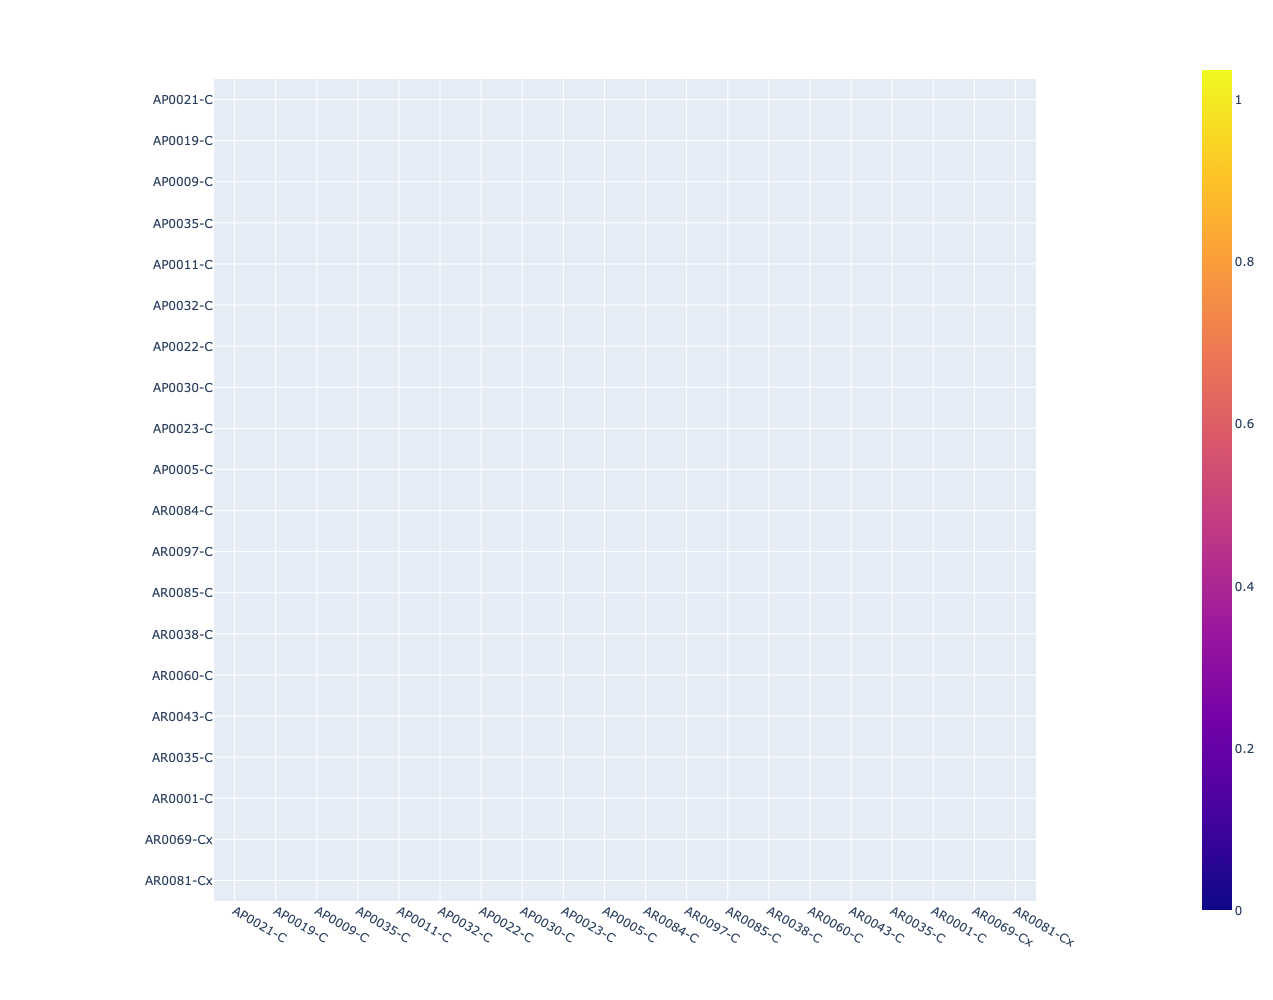

In [14]:
px.imshow(fr_ao_ibd1_df, width = 1000, height = 1000)

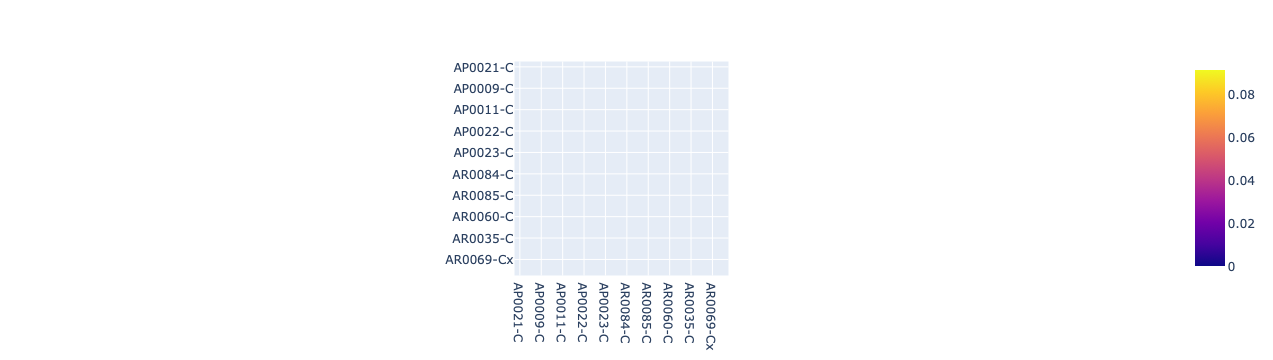

In [15]:
px.imshow(fr_ao_ibd2_df)

Mali (gambiae) & Mali (coluzzii)

In [17]:
mlg_mlc_ibd1_df, mlg_mlc_ibd2_df, sample_ids = compute_ibd(
        sample_sets1=['AG1000G-ML-A','AG1000G-ML-B'],
        cohort_size1=10,
        sample_query1="taxon == 'gambiae'",
        sample_sets2=['AG1000G-ML-A','AG1000G-ML-B'],
        cohort_size2=10,
        sample_query2="taxon == 'coluzzii'",
        site_mask='gamb_colu',
        prefix="MLG_MLC_50000_5000",
        save_path="MLG_MLC_50000_5000",
        ibd1_size = 50000,
        ibd2_size = 5000
    )

2RL
Loading genotypes
computing allele counts
retaining 2535435 variants and removing 77909455


0it [00:00, ?it/s]

3RL
Loading genotypes
computing allele counts
retaining 2072357 variants and removing 63834901


0it [00:00, ?it/s]

X
Loading genotypes
computing allele counts
retaining 279920 variants and removing 16082889


0it [00:00, ?it/s]

reading ibd1 2RL...
reading ibd2 2RL...
reading ibd1 3RL...
reading ibd2 3RL...
reading ibd1 X...
reading ibd2 X...
computing...


In [ ]:
ag3.sample_metadata().query("sample_id in @sample_ids")

,sample_id,partner_sample_id,contributor,country,location,year,month,latitude,longitude,sex_call,...,admin1_name,admin1_iso,admin2_name,taxon,cohort_admin1_year,cohort_admin1_month,cohort_admin1_quarter,cohort_admin2_year,cohort_admin2_month,cohort_admin2_quarter
13670,AZ0296-C,MA7-44,Austin Burt,Mali,Kababougou,2014,8,12.89,-8.15,F,...,Koulikouro,ML-2,Kati,coluzzii,ML-2_colu_2014,ML-2_colu_2014_08,ML-2_colu_2014_Q3,ML-2_Kati_colu_2014,ML-2_Kati_colu_2014_08,ML-2_Kati_colu_2014_Q3
13671,AZ0297-C,MA7-7,Austin Burt,Mali,Kababougou,2014,8,12.89,-8.15,F,...,Koulikouro,ML-2,Kati,coluzzii,ML-2_colu_2014,ML-2_colu_2014_08,ML-2_colu_2014_Q3,ML-2_Kati_colu_2014,ML-2_Kati_colu_2014_08,ML-2_Kati_colu_2014_Q3
13678,AZ0306-C,MA6-10,Austin Burt,Mali,Kababougou,2014,8,12.89,-8.15,F,...,Koulikouro,ML-2,Kati,gambiae,ML-2_gamb_2014,ML-2_gamb_2014_08,ML-2_gamb_2014_Q3,ML-2_Kati_gamb_2014,ML-2_Kati_gamb_2014_08,ML-2_Kati_gamb_2014_Q3
13679,AZ0307-C,MA6-18,Austin Burt,Mali,Kababougou,2014,8,12.89,-8.15,F,...,Koulikouro,ML-2,Kati,gambiae,ML-2_gamb_2014,ML-2_gamb_2014_08,ML-2_gamb_2014_Q3,ML-2_Kati_gamb_2014,ML-2_Kati_gamb_2014_08,ML-2_Kati_gamb_2014_Q3
13686,AZ0316-C,MA6-43,Austin Burt,Mali,Kababougou,2014,8,12.89,-8.15,F,...,Koulikouro,ML-2,Kati,gambiae,ML-2_gamb_2014,ML-2_gamb_2014_08,ML-2_gamb_2014_Q3,ML-2_Kati_gamb_2014,ML-2_Kati_gamb_2014_08,ML-2_Kati_gamb_2014_Q3
13699,AZ0331-C,MA4-17,Austin Burt,Mali,Kababougou,2014,8,12.89,-8.15,M,...,Koulikouro,ML-2,Kati,gambiae,ML-2_gamb_2014,ML-2_gamb_2014_08,ML-2_gamb_2014_Q3,ML-2_Kati_gamb_2014,ML-2_Kati_gamb_2014_08,ML-2_Kati_gamb_2014_Q3
13705,AZ0290-C,MA7-28,Austin Burt,Mali,Kababougou,2014,8,12.89,-8.15,F,...,Koulikouro,ML-2,Kati,coluzzii,ML-2_colu_2014,ML-2_colu_2014_08,ML-2_colu_2014_Q3,ML-2_Kati_colu_2014,ML-2_Kati_colu_2014_08,ML-2_Kati_colu_2014_Q3
13723,AZ0444-CW,MA11-28,Austin Burt,Mali,Tieneguebougou,2014,8,12.81,-8.08,F,...,Koulikouro,ML-2,Kati,coluzzii,ML-2_colu_2014,ML-2_colu_2014_08,ML-2_colu_2014_Q3,ML-2_Kati_colu_2014,ML-2_Kati_colu_2014_08,ML-2_Kati_colu_2014_Q3
13731,AZ0259-C,bc053,Nora Besansky,Mali,Bancoumana,2004,8,12.20,-8.20,F,...,Koulikouro,ML-2,Kati,gambiae,ML-2_gamb_2004,ML-2_gamb_2004_08,ML-2_gamb_2004_Q3,ML-2_Kati_gamb_2004,ML-2_Kati_gamb_2004_08,ML-2_Kati_gamb_2004_Q3
13745,AZ0277-C,mb102,Nora Besansky,Mali,Moribobougou,2004,8,12.69,-7.87,F,...,Koulikouro,ML-2,Kati,coluzzii,ML-2_colu_2004,ML-2_colu_2004_08,ML-2_colu_2004_Q3,ML-2_Kati_colu_2004,ML-2_Kati_colu_2004_08,ML-2_Kati_colu_2004_Q3


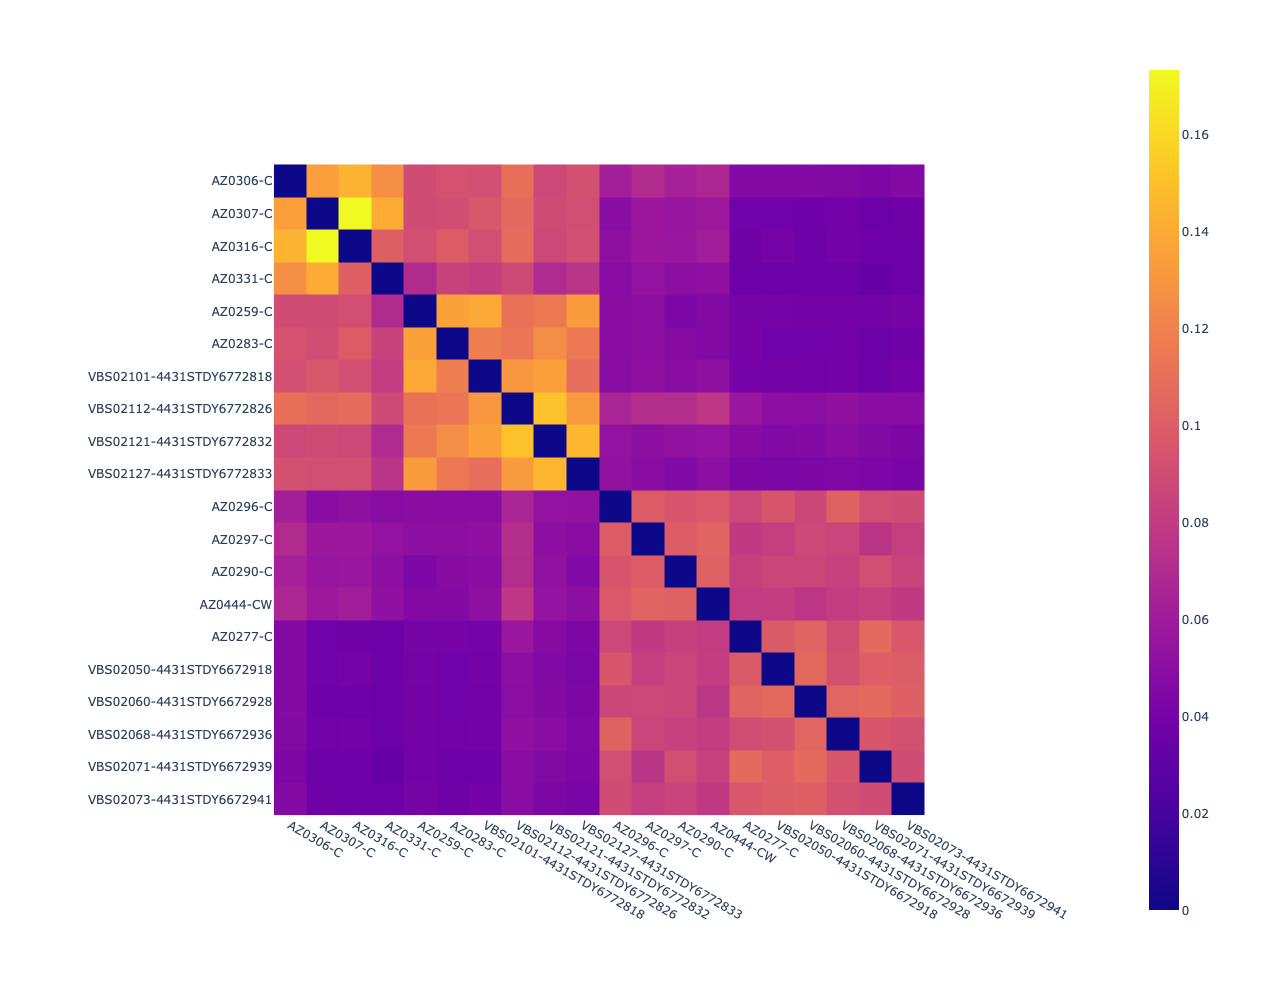

In [ ]:
px.imshow(mlg_mlc_ibd1_df, width = 1000, height = 1000)

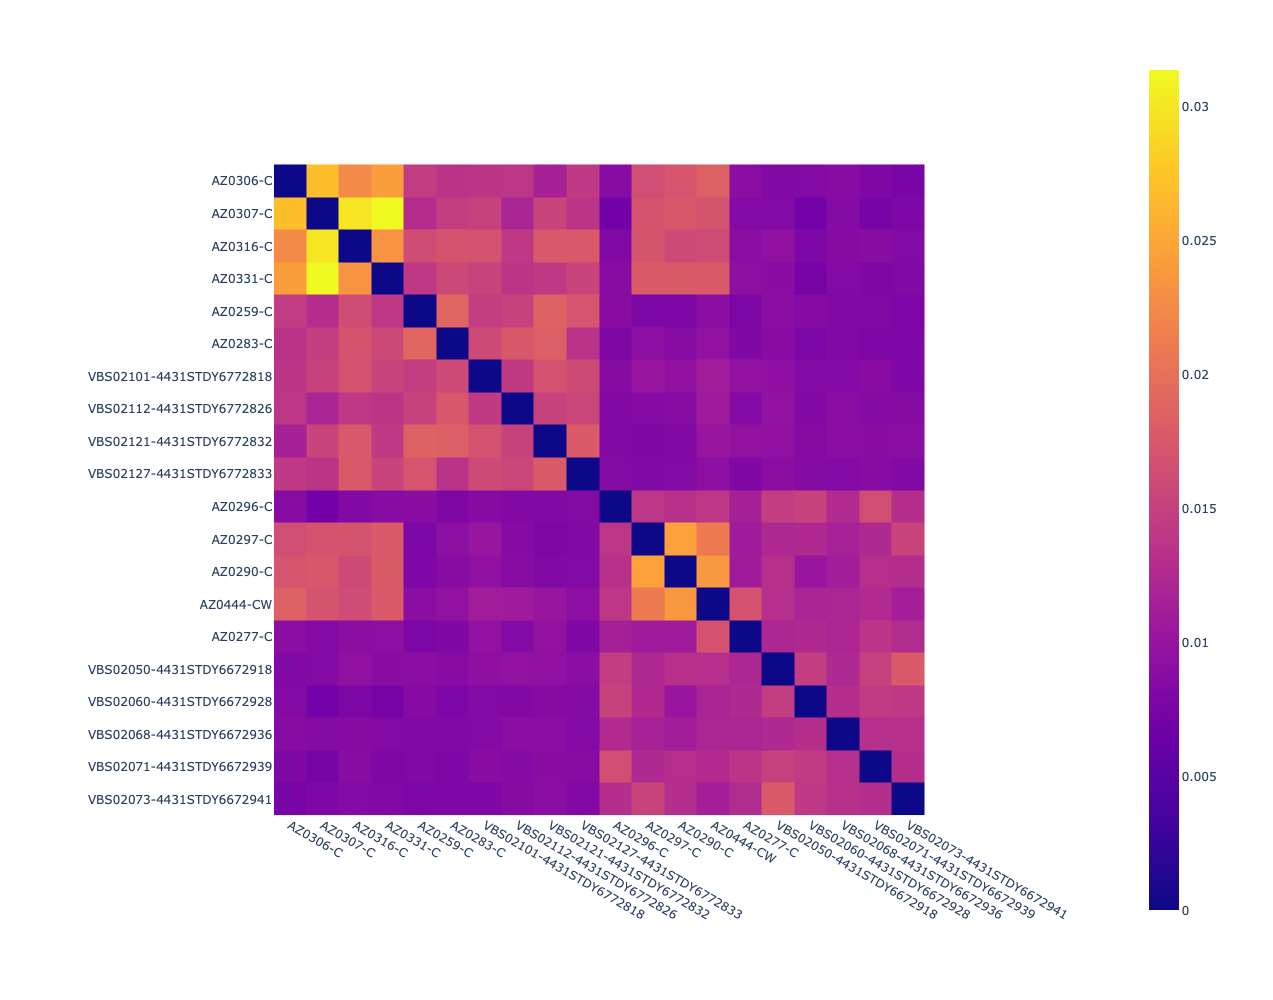

In [ ]:
px.imshow(mlg_mlc_ibd2_df, width = 1000, height = 1000)

Mali (coluzzii) & Burkina Faso (coluzzii)

In [16]:
mlc_bfc_ibd1_df, mlc_bfc_ibd2_df, sample_ids = compute_ibd(
        sample_sets1=['AG1000G-ML-A','AG1000G-ML-B'],
        cohort_size1=10,
        sample_query1="taxon == 'coluzzii'",
        sample_sets2=['AG1000G-BF-A','AG1000G-BF-B'],
        cohort_size2=10,
        sample_query2="taxon == 'coluzzii'",
        site_mask='gamb_colu',
        prefix="",
        save_path="MLC_BFC_50000_5000",
        ibd1_size = 50000,
        ibd2_size = 5000
    )

2RL
Loading genotypes
computing allele counts
retaining 2319098 variants and removing 78125792


0it [00:00, ?it/s]

3RL
Loading genotypes
computing allele counts
retaining 2044966 variants and removing 63862292


0it [00:00, ?it/s]

X
Loading genotypes
computing allele counts
retaining 282893 variants and removing 16079916


0it [00:00, ?it/s]

reading ibd1 2RL...
reading ibd2 2RL...
reading ibd1 3RL...
reading ibd2 3RL...
reading ibd1 X...
reading ibd2 X...
computing...


In [11]:
ag3.sample_metadata().query("sample_id in @sample_ids")

,sample_id,partner_sample_id,contributor,country,location,year,month,latitude,longitude,sex_call,...,admin1_name,admin1_iso,admin2_name,taxon,cohort_admin1_year,cohort_admin1_month,cohort_admin1_quarter,cohort_admin2_year,cohort_admin2_month,cohort_admin2_quarter
11813,AB0100-C,BF6-2,Austin Burt,Burkina Faso,Bana Village,2012,7,11.233,-4.472,F,...,Hauts-Bassins,BF-09,Houet,coluzzii,BF-09_colu_2012,BF-09_colu_2012_07,BF-09_colu_2012_Q3,BF-09_Houet_colu_2012,BF-09_Houet_colu_2012_07,BF-09_Houet_colu_2012_Q3
11814,AB0101-C,BF6-3,Austin Burt,Burkina Faso,Bana Village,2012,7,11.233,-4.472,F,...,Hauts-Bassins,BF-09,Houet,coluzzii,BF-09_colu_2012,BF-09_colu_2012_07,BF-09_colu_2012_Q3,BF-09_Houet_colu_2012,BF-09_Houet_colu_2012_07,BF-09_Houet_colu_2012_Q3
11844,AB0138-Cx,BF2-19,Austin Burt,Burkina Faso,Souroukoudinga,2012,7,11.238,-4.235,F,...,Hauts-Bassins,BF-09,Houet,coluzzii,BF-09_colu_2012,BF-09_colu_2012_07,BF-09_colu_2012_Q3,BF-09_Houet_colu_2012,BF-09_Houet_colu_2012_07,BF-09_Houet_colu_2012_Q3
11920,AB0223-C,BFSour 56.1,Austin Burt,Burkina Faso,Souroukoudinga,2012,7,11.238,-4.235,F,...,Hauts-Bassins,BF-09,Houet,coluzzii,BF-09_colu_2012,BF-09_colu_2012_07,BF-09_colu_2012_Q3,BF-09_Houet_colu_2012,BF-09_Houet_colu_2012_07,BF-09_Houet_colu_2012_Q3
11981,AB0327-C,BF18-3,Austin Burt,Burkina Faso,Bana Village,2014,7,11.233,-4.472,F,...,Hauts-Bassins,BF-09,Houet,coluzzii,BF-09_colu_2014,BF-09_colu_2014_07,BF-09_colu_2014_Q3,BF-09_Houet_colu_2014,BF-09_Houet_colu_2014_07,BF-09_Houet_colu_2014_Q3
11991,AB0339-C,BF18-14,Austin Burt,Burkina Faso,Bana Village,2014,7,11.233,-4.472,F,...,Hauts-Bassins,BF-09,Houet,coluzzii,BF-09_colu_2014,BF-09_colu_2014_07,BF-09_colu_2014_Q3,BF-09_Houet_colu_2014,BF-09_Houet_colu_2014_07,BF-09_Houet_colu_2014_Q3
11997,AB0354-C,BF18-21,Austin Burt,Burkina Faso,Bana Village,2014,7,11.233,-4.472,M,...,Hauts-Bassins,BF-09,Houet,coluzzii,BF-09_colu_2014,BF-09_colu_2014_07,BF-09_colu_2014_Q3,BF-09_Houet_colu_2014,BF-09_Houet_colu_2014_07,BF-09_Houet_colu_2014_Q3
12011,AB0368-C,BF18-37,Austin Burt,Burkina Faso,Bana Village,2014,7,11.233,-4.472,M,...,Hauts-Bassins,BF-09,Houet,coluzzii,BF-09_colu_2014,BF-09_colu_2014_07,BF-09_colu_2014_Q3,BF-09_Houet_colu_2014,BF-09_Houet_colu_2014_07,BF-09_Houet_colu_2014_Q3
12062,AB0505-C,BF13-13,Austin Burt,Burkina Faso,Souroukoudinga,2014,7,11.238,-4.235,F,...,Hauts-Bassins,BF-09,Houet,coluzzii,BF-09_colu_2014,BF-09_colu_2014_07,BF-09_colu_2014_Q3,BF-09_Houet_colu_2014,BF-09_Houet_colu_2014_07,BF-09_Houet_colu_2014_Q3
12064,AB0509-C,BF24-55,Austin Burt,Burkina Faso,Souroukoudinga,2014,7,11.238,-4.235,F,...,Hauts-Bassins,BF-09,Houet,coluzzii,BF-09_colu_2014,BF-09_colu_2014_07,BF-09_colu_2014_Q3,BF-09_Houet_colu_2014,BF-09_Houet_colu_2014_07,BF-09_Houet_colu_2014_Q3


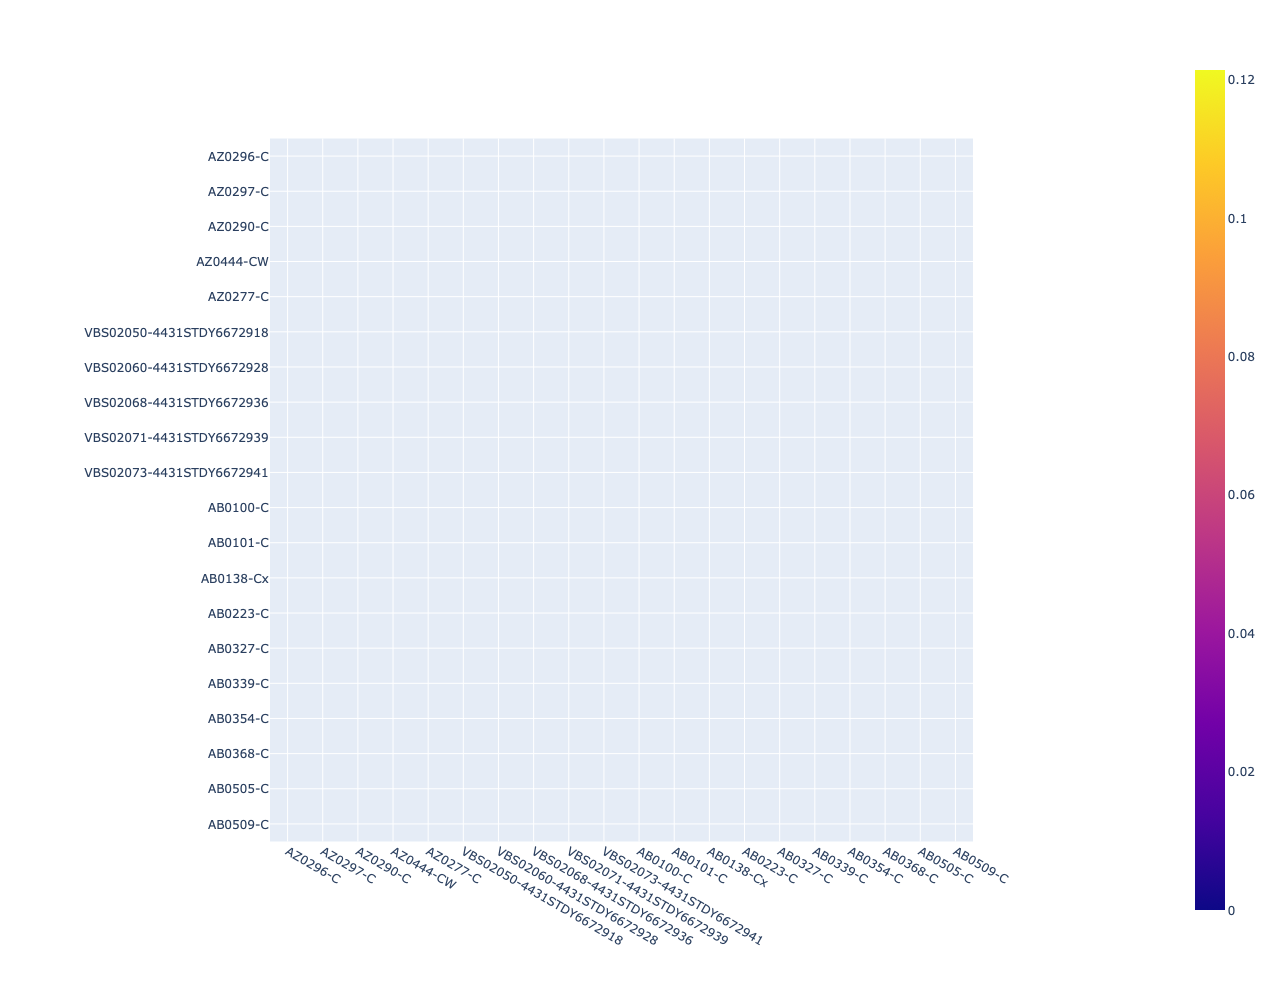

In [12]:
px.imshow(mlc_bfc_ibd1_df, width = 1000, height = 1000)

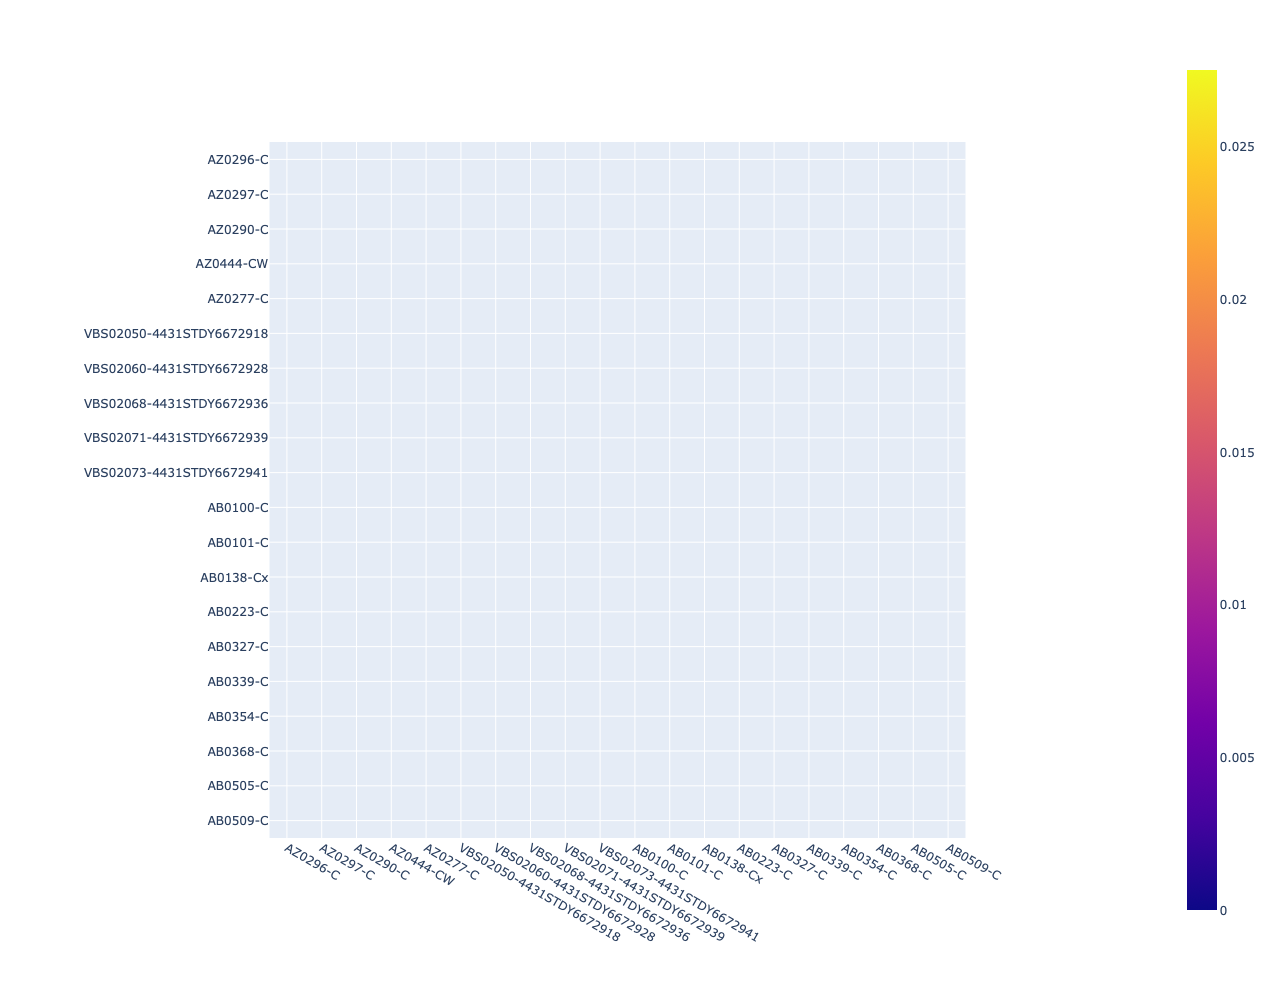

In [13]:
px.imshow(mlc_bfc_ibd2_df, width = 1000, height = 1000)